In [1]:
install.packages("install.load")
library(install.load)

install_load("xml2")
install_load("data.table")
install_load("lsa")
install_load("tm")
install_load("RWeka")
install_load("scales")
install_load("readxl")
install_load("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fastmatch’, ‘checkmate’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’


Loading required package: SnowballC

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Loading required package: NLP

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Discount retrieval based on customers and descriptions

In the following sections we will show a method to retrieve discount rates for products based on previous transactions. While it may seems a trivial task at first, we need to take into account the fact that most of the times discounting is not performed in a structured way with estabileshed rules but rather on the basis of the product and the client that is buying it. Businesses may decide for lower or higher prices depending on the client, for instance.


## Dataset

Data is obtained from a the famous Superstore dataset, bundled with Tableu visualization software.

The dataset is obtained from https://danguetta.github.io/research/globalsuperstore.

In [2]:
system("wget https://danguetta.github.io/files/research/globalsuperstore/GlobalSuperstore.xls")
data <- data.frame(read_excel("./GlobalSuperstore.xls"))

## Searching for a similar document

Let's first find a way to search for similar documents given a query.

In [3]:
descriptions <- data$Product.Name
head(descriptions)

[1] "Plantronics CS510 - Over-the-Head monaural Wireless Headset System"
[2] "Novimex Executive Leather Armchair, Black"                         
[3] "Nokia Smart Phone, with Caller ID"                                 
[4] "Motorola Smart Phone, Cordless"                                    
[5] "Sharp Wireless Fax, High-Speed"                                    
[6] "Samsung Smart Phone, with Caller ID"

We can use those descriptions to build a term-document matrix. First we will preprocess the dataset by lowering the text, removing punctuation, stopwords, numbers and symbols.

In [4]:
preprocessDescriptions <- function(descriptions) {
  corpus <- Corpus(VectorSource(descriptions))
  corpus <- tm_map(corpus, tolower)
  corpus <- tm_map(corpus, removePunctuation)
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  corpus <- tm_map(corpus, removeNumbers)
  
  # remove consecutive spaces
  consecutiveSpacesRe <- "\\s+"
  corpus <- tm_map(corpus, function(d) { gsub(consecutiveSpacesRe, " ", d) })
  
  # trim spaces
  trimRe <- "^\\s+|\\s+$"
  corpus <- tm_map(corpus, function(d) { gsub(trimRe, "", d) })

  return(corpus)
}

corpus <- preprocessDescriptions(descriptions)
head(corpus$content)

Warning message in tm_map.SimpleCorpus(corpus, tolower):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("en")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(d) {:
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(d) {:
“transformation drops documents”


[1] "plantronics cs overthehead monaural wireless headset system"
[2] "novimex executive leather armchair black"                   
[3] "nokia smart phone caller id"                                
[4] "motorola smart phone cordless"                              
[5] "sharp wireless fax highspeed"                               
[6] "samsung smart phone caller id"

We can now build a term-document matrix based on the preprocessed dataset.


In [5]:
tdm <- TermDocumentMatrix(corpus)
tdm

<<TermDocumentMatrix (terms: 2041, documents: 51290)>>
Non-/sparse entries: 211625/104471265
Sparsity           : 100%
Maximal term length: 23
Weighting          : term frequency (tf)

As we can see the matrix is really sparse. A lot of terms in the matrix are only used in few documents.

We would like to keep only those terms that are appearing in at least $2$ documents, otherwise they wouldn't bring any added value to the document description. This means that, given $N$ as the number of documents, we only want to keep terms whose sparsity is at most $1 - \frac{2}{N}$.

In [6]:
maxSparsity <- 1 - 2/tdm$nrow
tdm <- removeSparseTerms(tdm, maxSparsity)
tdm

<<TermDocumentMatrix (terms: 374, documents: 51290)>>
Non-/sparse entries: 194542/18987918
Sparsity           : 99%
Maximal term length: 14
Weighting          : term frequency (tf)

Indeed we end up removing a lot of terms.

We will compute each term representation by using TF-IDF in order to give more importance to rare terms that often carry more semantically relevant information compared to common terms.

In [7]:
tdm.terms <- rownames(tdm)
tdm.m <- as.matrix(tdm)

# TF-IDF application
tdm.m <- lw_logtf(tdm.m) * ( 1 - entropy(tdm.m))

### Searching in the lexical space

Let's say we want to search documents related to  *book shelf*. We can do that by directly turning the search query into a document first.


In [8]:
tdm.makequery <- function(text) {
  q <- query(text, tdm.terms)
  return(as.vector(lw_logtf(q) * ( 1-entropy(tdm.m))))
}

query.text <- "book shelf"
query <- tdm.makequery(query.text)

And compute the cosine similarity between the query and the documents.

In [9]:
top <- function(n, ...) order(..., decreasing = T)[1:n]

sim.docs <- apply(tdm.m, 2, cosine, as.vector(query))
df <- data.frame(description=corpus$content, similarity=sim.docs)
# remove duplicated descriptions
df <- df %>% group_by(description) %>% slice_sample(n = 1)

top10 <- top(10, df$similarity)
df[top10,]

description,similarity
<chr>,<dbl>
avoid verbal orders carbonless minifold book,0.8223031
things today spiral book,0.8223031
black print carbonless x rapid memo book,0.5901705
adams telephone message book wfrequentlycalled numbers space messages per book,0.5289688
message book wirebound four x formspg dupl setsbook,0.5004628
wirebound voice message log book,0.5004628
adams write n stick phone message book x messages,0.4549196
recycled desk saver line book x,0.4468044
memo book message capacity ” x ”,0.4443944


Indeed we end up with lots of results mentioning books but none of them is about shelf, even though the cosine similarity is pretty high.


### Searching in the latent semantical space

By exploiting Latent Semantic Analysis (LSA) we can try to extract semantic information from documents and try to search in that space, rather than the lexical one. This will give us more chances in retrieving documents based on their semantic rather than on their lexical structure.

We will first of all approximate the matrix in a low-rank matrix.

In [10]:
tdm.lsa <- lsa(tdm.m)

Warning message in lsa(tdm.m):
“[lsa] - there are singular values which are zero.”


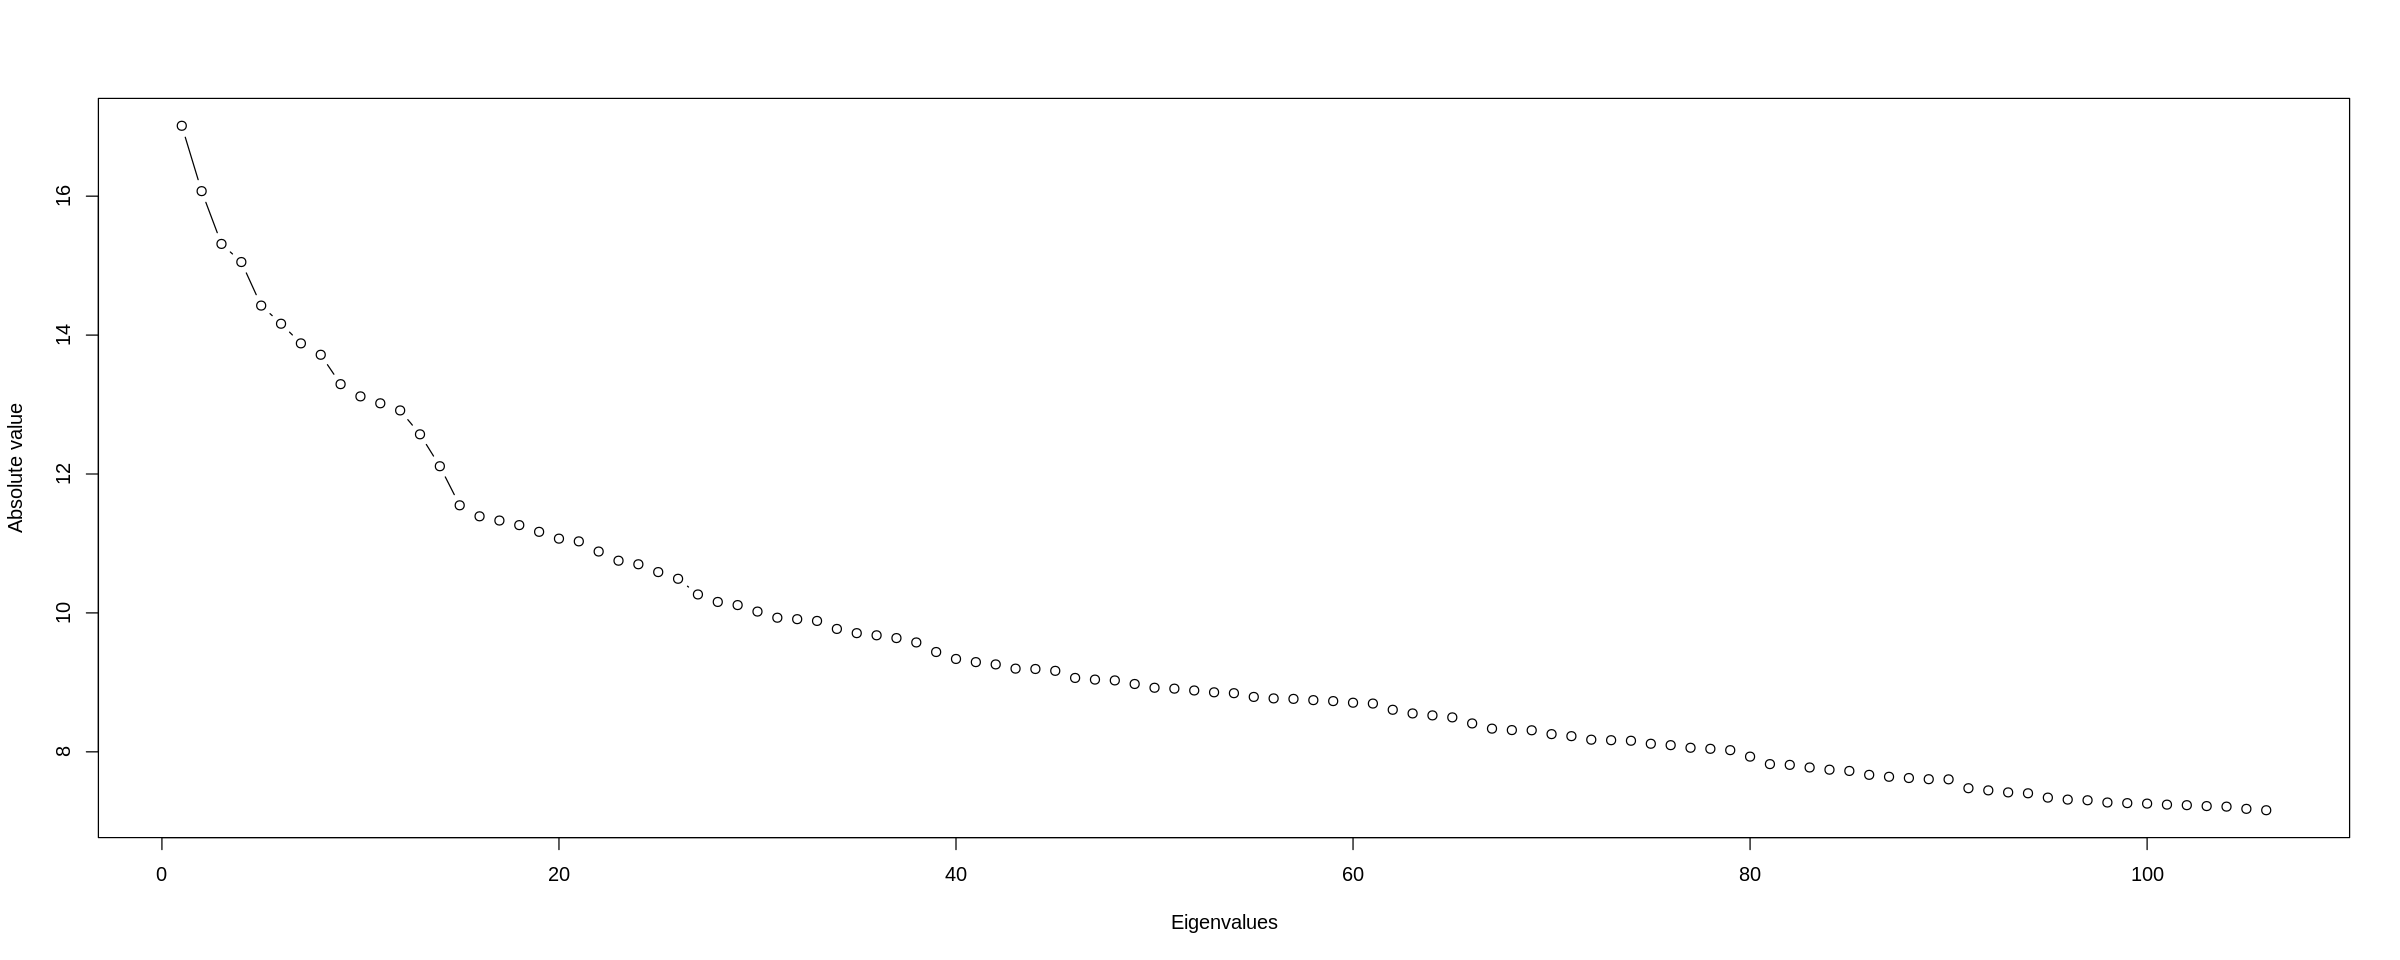

In [11]:
options(repr.plot.width=20, repr.plot.height=8)
plot(1:length(tdm.lsa$sk), tdm.lsa$sk, 
     type="b",
     xlab="Eigenvalues", 
     ylab="Absolute value")

As one would expect, most information variance seems to be contained in the first eigenvectors of the document's and term's latent space.

We can search for similar documents by folding the query into the latent space by using $q^T U$ then computing the cosine similarity between the query


In [12]:
query <- query(query.text, rownames(tdm))
query.ls <- as.vector(t(query) %*% tdm.lsa$tk)

sim.docs <- apply(tdm.lsa$dk, 1, cosine, query.ls)
df <- data.frame(description=corpus$content, similarity=sim.docs)
# remove duplicated descriptions
df <- df %>% group_by(description) %>% slice_sample(n = 1)

top10 <- top(10, df$similarity)
df[top10,]

description,similarity
<chr>,<dbl>
osullivan living dimensions shelf bookcases,0.9348726
osullivan shelf heavyduty bookcases,0.9251164
ikea shelf cabinet traditional,0.9114407
dania shelf cabinet traditional,0.8980754
sauder shelf cabinet traditional,0.8955717
ikea shelf cabinet mobile,0.8949120
bush shelf cabinet traditional,0.8928963
ikea shelf cabinet pine,0.8811897
sauder shelf cabinet pine,0.8757414


If we compute the similarity on the semantic space we end up with much more meaningful results. In order to improve the result we might try to reduce the number of dimensions of the latent space. By doing that we would hopefully end up removing some noise from the latent space. We will select the number of dimensions by examining the (local) minimums of the curvature function $\frac{f(x)''}{(1 + f(x)')^{\frac{3}{2}}}$

Warning message in s2/(1 + s1^2)^(3/2):
“longer object length is not a multiple of shorter object length”


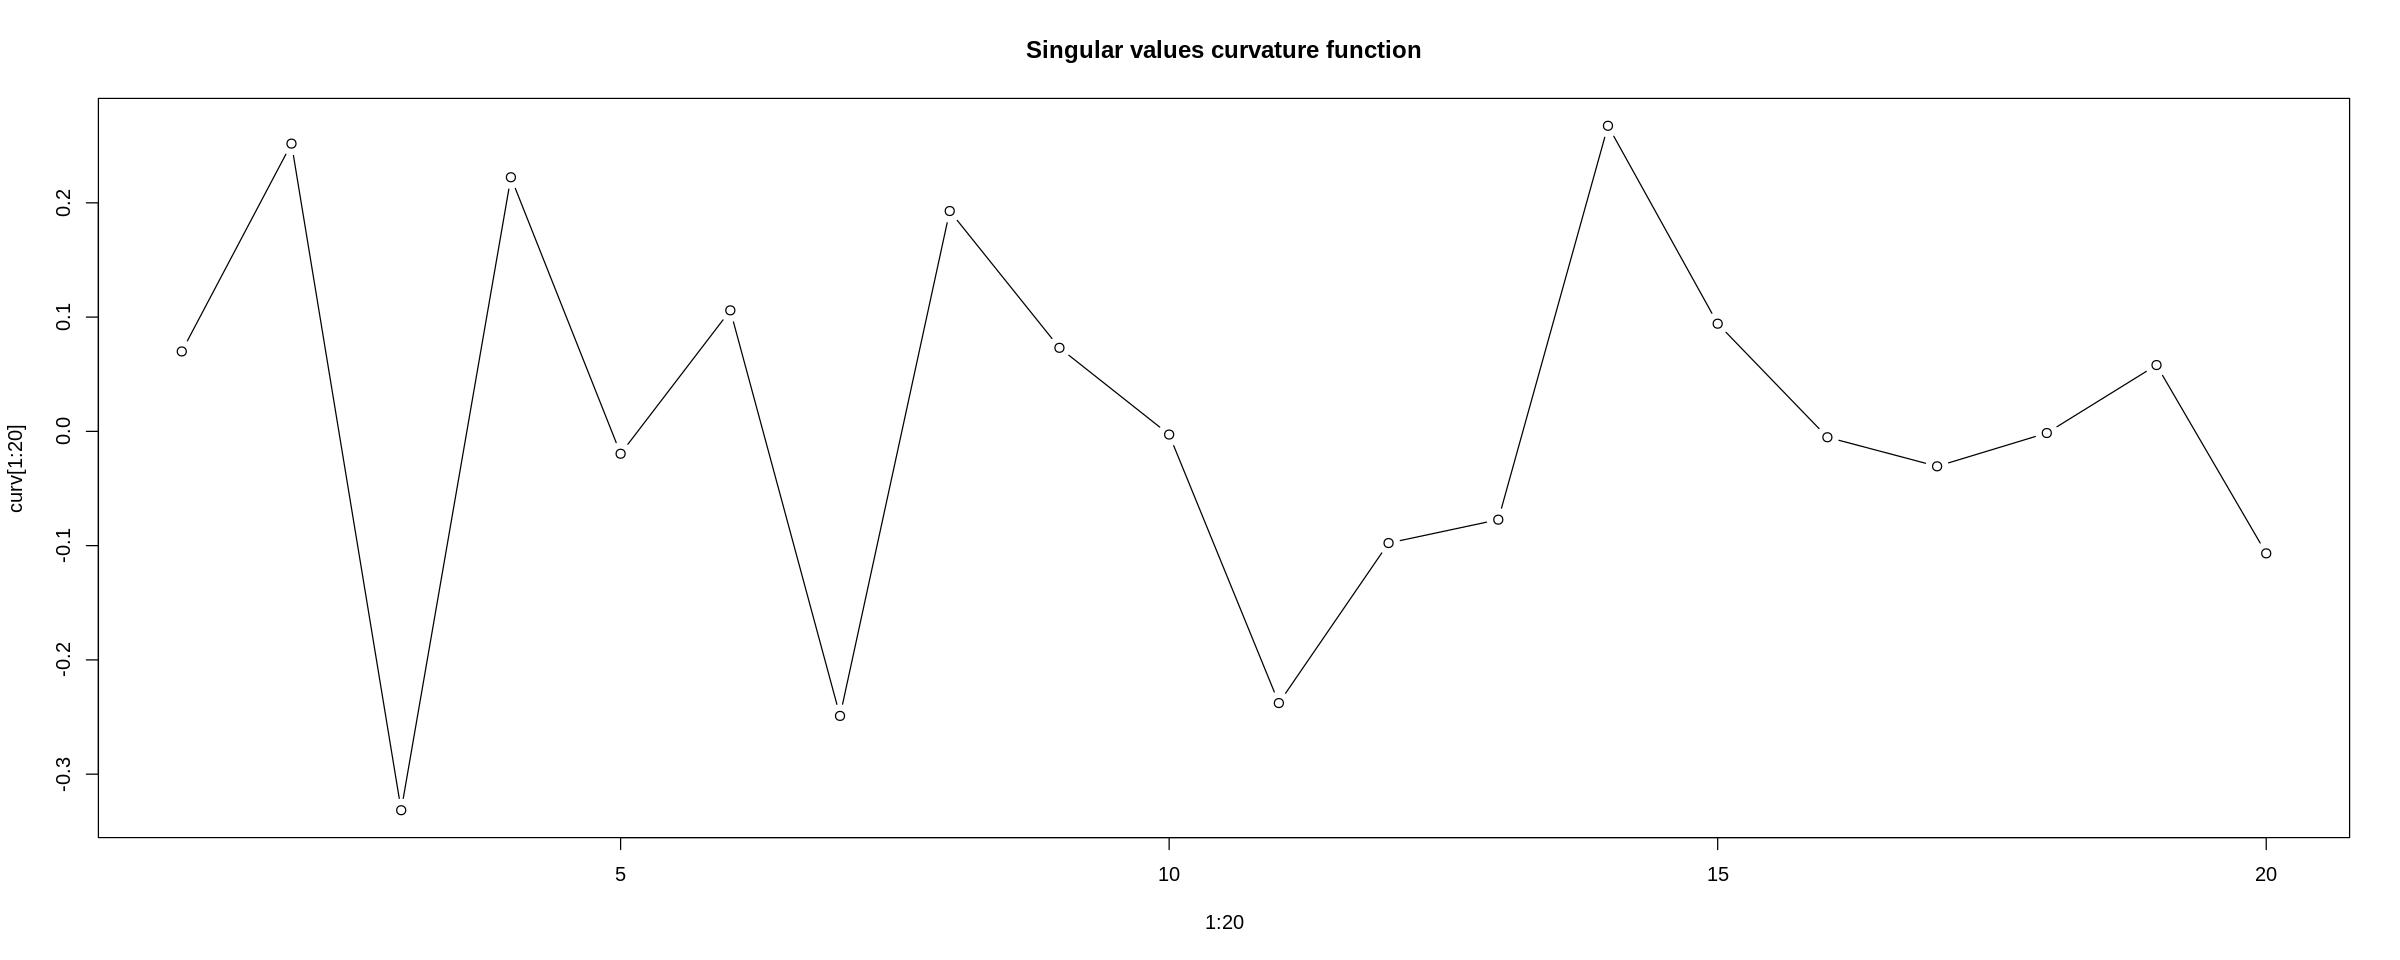

In [13]:
# we will compute derivates by using forward difference approximation
derivative <- function(x) x[2:length(x)] - x[1:(length(x)-1)]

s1 <- derivative(tdm.lsa$sk)
s2 <- derivative(s1)

curv <- s2 / (1 + s1^2)^(3 / 2)
plot(1:20, curv[1:20], type="b", main="Singular values curvature function")

We can see we have a local minima on the $3rd$ singular value. However, from plotting all the eigenvalues we've seen that most data is contained in the first 20-ish dimensions. Taking too few eigenvectors will probably yield bad results, because of a huge loss of information.

In [14]:
sim.docs <- apply(tdm.lsa$dk[,1:3], 1, cosine, query.ls[1:3])
df <- data.frame(description=corpus$content, similarity=sim.docs)
# remove duplicated descriptions
df <- df %>% group_by(description) %>% slice_sample(n = 1)

top10 <- top(10, df$similarity)
df[top10,]

description,similarity
<chr>,<dbl>
panasonic calculator red,0.9998306
safco planmaster boards w x d white melamine,0.9995739
ikea shelf cabinet metal,0.9995249
tops money receipt book consecutively numbered red,0.9995242
panasonic phone red,0.9995054
panasonic inkjet red,0.9994299
bush shelf cabinet metal,0.9993959
okidata calculator red,0.9993632
sauder shelf cabinet metal,0.9993549


The previous arguments are confirmed by an empirical evaluation, using too few dimensions brings distances between vectors to be extremely close one to another. 
Let's see however if using the first $11$ dimensions yields better results.

In [15]:
sim.docs <- apply(tdm.lsa$dk[,1:11], 1, cosine, query.ls[1:11])
df <- data.frame(description=corpus$content, similarity=sim.docs)
# remove duplicated descriptions
df <- df %>% group_by(description) %>% slice_sample(n = 1)

top10 <- top(10, df$similarity)
df[top10,]

description,similarity
<chr>,<dbl>
osullivan living dimensions shelf bookcases,0.9891581
osullivan shelf heavyduty bookcases,0.9877933
atlantic metals mobile shelf bookcases custom colors,0.9854500
ikea shelf cabinet traditional,0.9818388
bush shelf cabinet traditional,0.9816737
sauder shelf cabinet traditional,0.9816378
dania shelf cabinet traditional,0.9814320
ikea shelf cabinet mobile,0.9813458
bush shelf cabinet mobile,0.9811302


Using $11$ dimension finds better results with respect to the first $3$ dimensions, however distances are still cluttered. It's arguably better to build a latent space in which distances are more well spread in the vectorial space, to mantain a bigger margin between different elements. In the following we will use all the dimensions available.

### Discount suggestion

Let's see if retrieved documents can be used as a guide to discounting.


In [16]:
sim.docs <- apply(tdm.lsa$dk, 1, cosine, query.ls)
top10 <- top(5, sim.docs)
data.frame(description=corpus[top10]$content, 
           similarity=sim.docs[top10],
           price=data[top10,]$Discount)

,description,similarity,price
,<chr>,<dbl>,<dbl>
1899,osullivan living dimensions shelf bookcases,0.9348726,0.00
2297,osullivan living dimensions shelf bookcases,0.9348726,0.20
2358,osullivan living dimensions shelf bookcases,0.9348726,0.32
3265,osullivan living dimensions shelf bookcases,0.9348726,0.15
4382,osullivan living dimensions shelf bookcases,0.9348726,0.15


We get relevant results but discount rates aren't very helpful in this form. Even though we can't predict exactly how discounts are applied, since the dataset doesn't disclose this information, it's common knowledge that the amount of discount applied to customer $A$ might be different from the discount applied to customer $B$. Those differences comes from the amount of orders the client usually performs, the shipping method that it's involved, the region from which the client is ordering and probably many more.

In order to give a better information retrieval system we need to address this causes. In the following section we will show that by taking into account the client that is actually making the order we can get different results than only relying on semantic text search.

## Querying in the clients space

In order to evaluate clients similarity we will make use of the same techniques that we used in the previous sections. In particular, we'll build a matrix $M^{\text{terms} \times \text{clients}}$. Each entry $M_{i,j}$ will be the frequency of the term $i$ for client $j$. We will then exploit TF-IDF to give importance to rare term and lower the importance of common terms in a balanced way.

In this way clients that usually make similar order will end up with a similar vector representation.
Of course this is an oversimplification in customer segmentation, but as we will see it already helps in achieving more explainable results. 

In [17]:
descriptions <- sapply(unique(data$Customer.ID ), function(c) {
  paste(data[data$Customer.ID == c,]$Product.Name, collapse = " ")
})

corpus <- preprocessDescriptions(descriptions)
head(corpus$content)

RH-19495 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              "plantronics cs overthehead monaural wireless headset system bevis round bullnose high table top safco rocking chair red office star steel folding chair black harbour creations executive leather armchair red memorex router bluetooth cisco audio dock caller id samsung speaker phone cordless fellowes lockers wire frame fellowes shelving wire frame novimex swivel stool red ames interoffice envelope securitytint sanford sketch pad blue cisco audio dock cordless sandisk flash drive erganomic sandisk note cards premium hon bag chairs red ikea floating shelf set traditional cardinal binding machine clear novimex rocking chair set two sandisk keyboard programmable eldon door stop duo pack eaton premium continuousfeed paper cotton letter size white shtsbox apple headset cordless personal creations ink jet cards labels xerox xerox rogers trays industrial sandisk numeric keypad bluetooth sanford pencil sharpener water color kleencut ruler serrated ames interoffice envelope recycled sandisk computer printout paper multicolor globeweis interoffice envelope securitytint acco binder covers durable binney smith pencil sharpener easyerase xerox bic pencil sharpener easyerase stockwell staples metal ames peel seal recycled novimex legal exhibit labels alphabetical avery binder recycled xerox memo slips recycled kleencut box cutter steel avery durable binders avery round labels alphabetical wilson jones hole reinforcements recycled wilson jones hole reinforcements clear stanley highlighters water color" 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [18]:
tcm <- TermDocumentMatrix(corpus)
tcm

<<TermDocumentMatrix (terms: 2041, documents: 1590)>>
Non-/sparse entries: 155941/3089249
Sparsity           : 95%
Maximal term length: 23
Weighting          : term frequency (tf)

As in the previous experiments, we will remove all of those terms that don't appear in at least two different clients.


In [19]:
maxSparsity <- 1 - 2/tcm$nrow
tcm <- removeSparseTerms(tcm, maxSparsity)
tcm

<<TermDocumentMatrix (terms: 1988, documents: 1590)>>
Non-/sparse entries: 155888/3005032
Sparsity           : 95%
Maximal term length: 21
Weighting          : term frequency (tf)

In [20]:
tcm.terms <- rownames(tcm)
tcm.m <- as.matrix(tcm)

# TF-IDF application
tcm.m <- lw_logtf(tcm.m) * ( 1 - entropy(tcm.m))

We will directly search in the semantic space since as we've already seen, in previous experiments, it helps finding better results.

In [21]:
tcm.lsa <- lsa(tcm.m)

tcm.lsa.t <- tcm.lsa$tk %*% diag( tcm.lsa$sk )
tcm.lsa.t.norm <- apply(tcm.lsa.t, 1, norm, type = "2")
tcm.lsa.t.normalized <- tcm.lsa.t / tcm.lsa.t.norm

tcm.lsa.c <- tcm.lsa$dk %*% diag( tcm.lsa$sk )
tcm.lsa.c.norm <- apply(tcm.lsa.c, 1, norm, type = "2")
tcm.lsa.c.normalized <- tcm.lsa.c / tcm.lsa.c.norm

Warning message in lsa(tcm.m):
“[lsa] - there are singular values which are zero.”


We could now try and experiment with client retrieval, but it would be hardly explainable with the current set of informations.

We will directly show how incorporating this information yields better results.

## Multidimensional search

Going back to the initial task we can now search semantically in both client and document space. This gives us the ability to search for semantical similarity in both the textual space and the client space.

In [22]:
top <- function(n, ...) order(..., decreasing = T)[1:n]

multisearch <- function(clientIdx, queryText) {
  client <- data$Customer.ID[clientIdx]

  # compute similarity with all other clients
  clients.sim <- apply(tcm.lsa.c, 1, cosine, as.vector(tcm.lsa.c[client,]))
  # exclude self
  clients.sim <- clients.sim[order(clients.sim, decreasing = T)][-1]
  clients.sim.df <- data.frame(clients.sim, client=names(clients.sim))

  # make query and turn it into ls
  query <- query(queryText, rownames(tdm))
  query.ls <- as.vector(t(query) %*% tdm.lsa$tk)

  # compute similarity between query and documents
  docs.sim <- apply(tdm.lsa$dk, 1, cosine, query.ls)
  docs.sim.df <- data.frame(docs.sim, 
    client=data$Customer.ID, 
    doc.index=names(docs.sim), 
    description=data$Product.Name,
    discount=data$Discount)

  df <- merge(clients.sim.df, docs.sim.df, by="client")

  # remove duplicated descriptions
  noDupDf <- df %>% group_by(description, docs.sim, clients.sim) %>% slice_sample(n = 1)
  top10 <- top(5, noDupDf$docs.sim, noDupDf$clients.sim)
  return(noDupDf[top10,])
}

In [23]:
paste("Customer ", data$Customer.ID[1])
multisearch(1, "book shelf")

[1] "Customer  RH-19495"

client,clients.sim,docs.sim,doc.index,description,discount
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
DP-13165,0.3982950,0.9348726,2297,O'Sullivan Living Dimensions 5-Shelf Bookcases,0.20
SS-20875,0.3664054,0.9348726,14358,O'Sullivan Living Dimensions 2-Shelf Bookcases,0.20
KH-16510,0.3406097,0.9348726,6766,O'Sullivan Living Dimensions 3-Shelf Bookcases,0.15
KN-16450,0.3178151,0.9348726,12851,O'Sullivan Living Dimensions 2-Shelf Bookcases,0.15
NR-18550,0.3133078,0.9348726,9977,O'Sullivan Living Dimensions 2-Shelf Bookcases,0.00


In [24]:
paste("Customer ", data$Customer.ID[2])
multisearch(2, "book shelf")

[1] "Customer  JR-16210"

client,clients.sim,docs.sim,doc.index,description,discount
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
DP-13165,0.4519056,0.9348726,2297,O'Sullivan Living Dimensions 5-Shelf Bookcases,0.20
KH-16510,0.3907061,0.9348726,6766,O'Sullivan Living Dimensions 3-Shelf Bookcases,0.15
KN-16450,0.3694181,0.9348726,12851,O'Sullivan Living Dimensions 2-Shelf Bookcases,0.15
AH-10465,0.3318349,0.9348726,2358,O'Sullivan Living Dimensions 5-Shelf Bookcases,0.32
AS-10090,0.3247304,0.9348726,7085,O'Sullivan Living Dimensions 5-Shelf Bookcases,0.20


Searching for discount rates on customer $1$ and customer $2$ gives us different results. Even though some customers are shared between the two, and so are some discount rates, additional insights are provided by the retrieved results.

The methodology provided above can be expanded in many ways, for instance one might follow the same rationale and compute similarity between customers areas.

And further expanding on it instead of naively sorting results by similarities one might combine the similarity results in different ways and learns how much each score should be weighted. In order to do that a supervised learning method needs to be employed.
One could approach such task by taking each discounted item in the dataset as training sample and the corresponding discount as target. Optimizing the scoring weights would then minimize the distance between the top-k retrieved results and the actual discount.